In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from keras.optimizers import Adam

import matplotlib.pyplot as plt

# Load and clean data

In [2]:
def convertDates(series):
    monthDict = {"Jan" : 1, "Feb" : 2, "Mar" : 3, "Apr" : 4, "May" : 5, "Jun" : 6, "Jul" : 7, "Aug" : 8, "Sep" : 9, "Oct" : 10, "Nov" : 11, "Dec" : 12}
    dates = []
    for val in series:
#         print(val)
        if (type(val) != type(0.1)):
            date = val.split("-")
            numDate = int(date[0]) + 100 * monthDict[date[1]] + 10000 * int(date[2])
            dates.append(numDate)
        else:
            dates.append(-1)
    return dates

# load all data
data0 = pd.read_table("./archive/ml-100k/u.data", delimiter="\t", names=["userId", "itemId", "rating", "timestamp"])
users0 = pd.read_table("./archive/ml-100k/u.user", delimiter="|", names=["userId", "age", "gender", "occupation", "zip"])
movies0 = pd.read_table("./archive/ml-100k/u.item", delimiter="|", names=["movieId", "title", "movieRelease", "videoRelease", "imbd", "unknown", "action", "adventure", "animation", "children", "comedy", "crime", "documentary", "drama", "fantasy", "noir", "horror", "musical", "mystery", "romance", "scifi", "thriller", "war", "western"])

# create copies of data to clean
movies = movies0.drop(["videoRelease", "imbd", "movieRelease"], axis=1).dropna()
# movies.movieRelease = convertDates(movies.movieRelease)

In [3]:
movies.head()

,movieId,title,unknown,action,adventure,animation,children,comedy,crime,documentary,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


# Cluster the movies

In [4]:
# create X
X = movies.to_numpy()[:, 2:]

maxK = 0
scores = np.zeros(11)
maxScore = 0
maxModel = 0

for k in range(10, 21):
    kmeans = KMeans(n_clusters = k)
    print(k) # this is just for me to know the kernel hasn't frozen
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_, metric = 'euclidean')
    scores[k - 10] = score
    if score > maxScore:
        maxScore = score
        maxModel = kmeans
        maxK = k
        
movies["Cluster"] = maxModel.predict(X)
movies.head()

10
11
12
13
14
15
16
17
18
19
20


,movieId,title,unknown,action,adventure,animation,children,comedy,crime,documentary,...,noir,horror,musical,mystery,romance,scifi,thriller,war,western,Cluster
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,18
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,19
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,16
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,8


In [5]:
movies.Cluster.value_counts()

2     454
3     279
5      83
6      81
15     81
16     74
11     66
7      63
19     60
8      60
4      53
13     50
0      50
10     50
17     43
12     34
18     32
14     29
9      29
1      11
Name: Cluster, dtype: int64

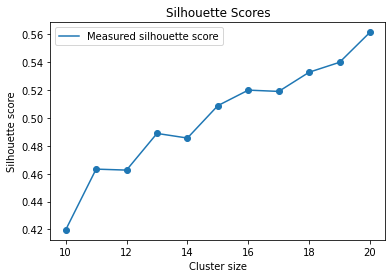

In [6]:
plt.title("Silhouette Scores")
plt.xlabel("Cluster size")
plt.ylabel("Silhouette score")
plt.plot(range(10, 21), scores, label="Measured silhouette score")
plt.scatter(range(10, 21), scores)
plt.legend()
plt.show()

# Generate reccomendations

In [7]:
# grab random user
user = np.random.choice(users0.userId)
# grab all movies ranked by that user
data = data0[data0.userId == user].drop(["userId", "timestamp"], axis=1)

# find cluster for each movie
clusters = []
for item in data.itemId:
    clusters.append(int(movies[movies["movieId"] == item].Cluster))

data["Clusters"] = clusters

# compute the averages for each cluster
averages = np.zeros((maxK))
for i in range(maxK):
    rated = data[data["Clusters"] == i].rating.to_numpy()
    if len(rated.flatten()) != 0:
        averages[i] = np.mean(rated)
    else:
        averages[i] = 0

In [8]:
favoredClusters = np.where(averages > 3.5)[0]
favoriteCluster = np.argmax(averages)
recommendations = movies[movies["Cluster"] == favoredClusters[0]].to_numpy()
favorites = movies[movies["Cluster"] == favoriteCluster]
for c in favoredClusters[1:]:
    likedMovies = movies[movies["Cluster"] == c].to_numpy()
    recommendations = np.vstack((recommendations, likedMovies))
    
recommendations = pd.DataFrame(recommendations, columns=movies.columns)
favorites[["movieId", "title"]].head(30)

,movieId,title
2,3,Four Rooms (1995)
10,11,Seven (Se7en) (1995)
11,12,"Usual Suspects, The (1995)"
155,156,Reservoir Dogs (1992)
197,198,Nikita (La Femme Nikita) (1990)
217,218,Cape Fear (1991)
330,331,"Edge, The (1997)"
335,336,Playing God (1997)
358,359,"Assignment, The (1997)"
360,361,Incognito (1997)


In [9]:
recommendations[["movieId", "title"]].head(10)

,movieId,title
0,38,"Net, The (1995)"
1,39,Strange Days (1995)
2,89,Blade Runner (1982)
3,96,Terminator 2: Judgment Day (1991)
4,121,Independence Day (ID4) (1996)
5,145,"Lawnmower Man, The (1992)"
6,175,Brazil (1985)
7,176,Aliens (1986)
8,179,"Clockwork Orange, A (1971)"
9,183,Alien (1979)
